# CMSE202 Final Project - Jack Nugent

An exploratory project for working with machine learning and prediction models

# Installs and Imports

By using the `yahoofinancials` package, we can download historical stock data for a specified time range. 

The Keras Tuner will be useful later when we build our predictive model.

If this is your first time using YahooFinancials or the Keras Tuner, run the following cell below. You only need to run it once.

In [1]:
!pip install yahoofinancials
!pip install -q -U keras-tuner

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

#Building our regression model
from sklearn.model_selection import train_test_split

# Biotech Analysis

One of the biggest names in Biotech right now is Pfizer. Alongside Pfizer we chose to analyze AbbVie and Biogen Inc. as they both have a long history, AbbVie being more constant and a generally safer investment whereas Biogen has a higher risk-reward ratio. The following cell imports the historical data for these three companies.

*Note: Moderna was also considered for modeling, but was not publicly traded until December 7th, 2018, and was excluded from this report due to small sample size.*

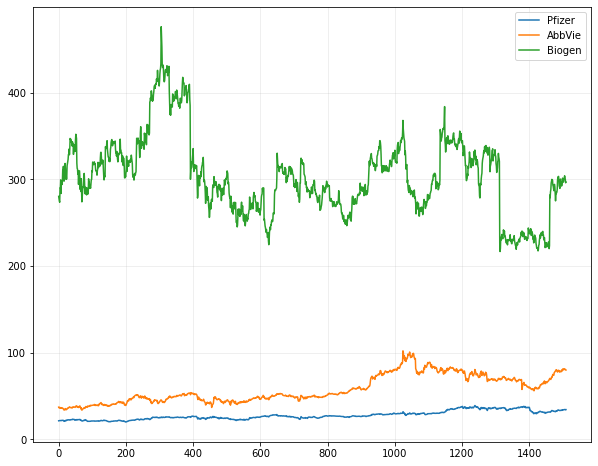

In [3]:
# Pfizer, AbbVie, Biogen Inc
start = '2014-01-01'
end = '2020-01-01'

ticker_syms =['PFE', 'ABBV', 'BIIB']
yahoo_financials = YahooFinancials(ticker_syms)

data = yahoo_financials.get_historical_price_data(start_date=start, 
                                                  end_date=end, 
                                                  time_interval='daily')

## The following code processes the data which is downloaded. 
##The package itself downloads a JSON file with a lot of information.
stocks = pd.DataFrame( { i:pd.DataFrame(data[i]['prices'])['adjclose'] for i in ticker_syms} )
stocks_pfe = pd.DataFrame(pd.DataFrame(data['PFE']['prices']) )

plt.figure(figsize=[10,8])
plt.plot(stocks)
plt.legend(['Pfizer', 'AbbVie', 'Biogen'])
plt.grid(alpha=0.25)
plt.show()

In [4]:
stocks_pfe.dtypes

date                int64
high              float64
low               float64
open              float64
close             float64
volume              int64
adjclose          float64
formatted_date     object
dtype: object

#### Preparing the Train-Test Split

Because we certainly can't wait for months of stock data to showcase our model, we can split the historic data into a training and testing set.

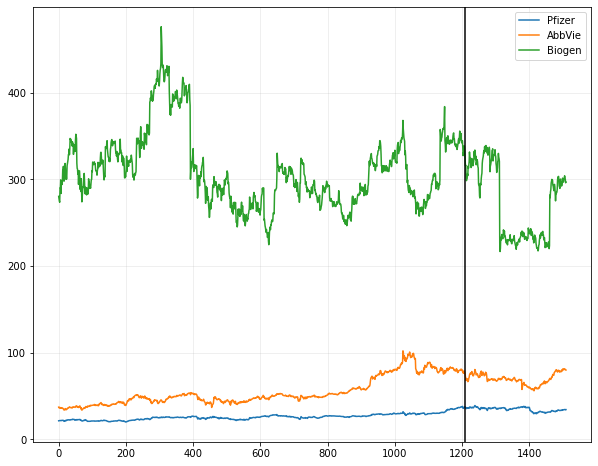

In [5]:
# Split into 80% train, 20% test
split = round(len(stocks)*.8)

train = stocks[:split]
test = stocks[split:]

plt.figure(figsize=[10,8])
plt.plot(stocks)
plt.legend(['Pfizer', 'AbbVie', 'Biogen'])
plt.grid(alpha=0.25)
plt.axvline(x=split, color = 'black') 

#### Normalizing Stock Prices

Another potentially helpful visualization may be the normalized stock prices, that is "How does the stock change compared to its first recorded price?"

In [6]:
# Compare all values to day 0 of our range
normalized_stocks = stocks.apply(lambda x: x / x[0])
normalized_stocks.head()

index = normalized_stocks['PFE'].index
start = index[0]
time = pd.to_timedelta(index-start).to_numpy().astype(int) 
# time = time / (1000000000 * 60 * 60 * 24)  #Converting nanoseconds to days
stock = normalized_stocks['PFE'].values

The following plot shows the change with respect to each stock's starting price in our time range, as noted by the horizontal black line. If the stock trends above the black line, it is increasing in value, and if the stock trends below the black line, it is decreasing in value.

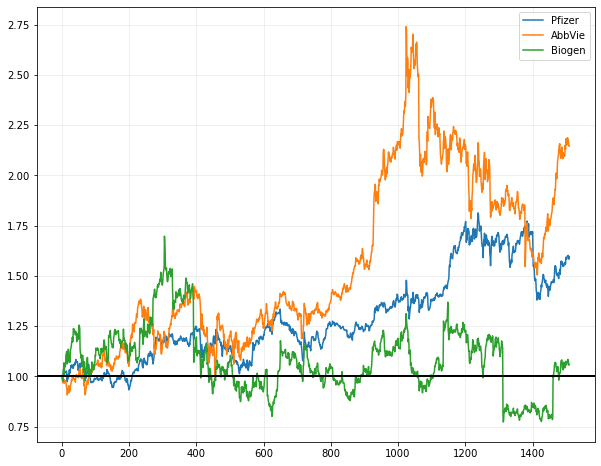

In [7]:
plt.figure(figsize=[10,8])
plt.plot(normalized_stocks)
plt.axhline(y = 1, color = "black", lw = 2)
plt.legend(['Pfizer', 'AbbVie', 'Biogen'])
plt.grid(alpha=0.25)
plt.show()

For the purpose of working with our models, let's look into a step-by-step process for modeling the company that hasn't left our minds in the past few months: Pfizer.

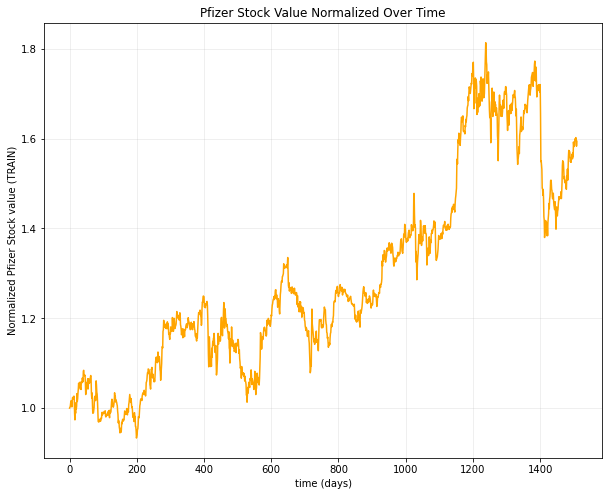

In [8]:
plt.figure(figsize=[10,8])
plt.plot(time,normalized_stocks['PFE'], color = 'orange')
plt.xlabel('time (days)')
plt.ylabel('Normalized Pfizer Stock value (TRAIN)')
plt.title("Pfizer Stock Value Normalized Over Time")
plt.grid(alpha=0.25)

We have a few methods at analyzing the stock's trend over time, for example we could smooth out the curve by calculating an **Exponential Moving Average**.

In [9]:
def calc_ema(prices, days, smooth=2):
    """
    Calculates an X-day exponential moving average for a passed set of stock data.
    
    prices: stock data to calculate EMA for.
    days: How many days in our EMA.
    smooth: (default: 2) The smoothing factor, a higher smoothing gives more recent 
            observations more influence on your EMA.
            
    return: Calculated EMA model.
    """
    ema = [sum(prices[:days]) / days]
    for price in prices[days:]:
        ema.append((price * (smooth / (1 + days))) + ema[-1] * (1 - (smooth / (1 + days))))
    return ema

# 20 day EMA for Pfizer
days = 20
pfizer = normalized_stocks['PFE']
ema = calc_ema(pfizer, days)

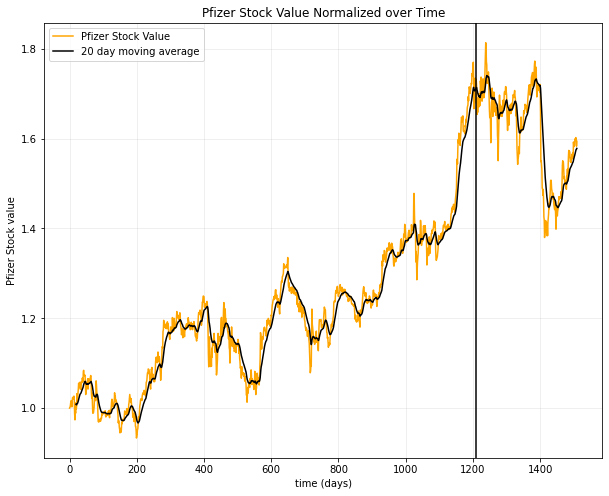

In [10]:
# 20 Day Moving Average
plt.figure(figsize=[10,8])
plt.plot(pfizer, color = 'orange', label='Pfizer Stock Value')
plt.plot(time[(days-1):], ema, color = 'black', label = "{} day moving average".format(days))
plt.xlabel('time (days)')
plt.ylabel('Pfizer Stock value')
plt.grid(alpha = 0.25)
plt.legend()
plt.title("Pfizer Stock Value Normalized over Time")
plt.axvline(x=split, color = 'black')
plt.show()

#### Deep Learning Model

We can also take a more artificially intelligent approach to our predictions. We can work on building up a **Recurrent Neural Network**. 

Recurrent Neural Networks (RNNs) recognize patterns in sequential data and use that to try and predict the most likely next scenario. 

A common RNN use case is for things like autocomplete on your phone, the predicted outcome is based on the data that came before it.

We will be applying this concept to Pfizer stock, can we use historic data to predict the next day of data?

In [11]:
split = round(len(stocks_pfe)*.8)

# 80% train, 20% test
# Split by date
train = stocks_pfe[:split].copy()
test = stocks_pfe[split:].copy()

# Drop categorical variables as well as adjclose
train_raw = train.drop(['date', 'formatted_date', 'adjclose'], axis = 1)
test_raw = test.drop(['date', 'formatted_date', 'adjclose'], axis = 1)

In [12]:
train_raw

,high,low,open,close,volume
0,29.032257,28.776091,28.908918,28.899431,18366266
1,29.250475,28.823528,28.833017,28.956356,15847312
2,29.364326,28.965843,29.193548,28.984819,25255421
3,29.430740,29.165085,29.278936,29.165085,23423042
4,29.402277,29.079697,29.203035,29.364326,24161053
...,...,...,...,...,...
1203,42.210625,40.227703,42.087288,40.616699,44299198
1204,41.707779,40.455406,40.578747,41.537003,30417070
1205,41.470589,40.777988,41.413662,40.910816,24002742
1206,41.726753,40.834915,41.129032,41.679317,22353654


SKLearn's MinMaxScaler is used here to scale and translate a feature to normalize it within a given range (here between 0 and 1).

In [13]:
scaler = MinMaxScaler()
print(train_raw[:5], "\n")

train = scaler.fit_transform(train_raw)
print(train[:5])

        high        low       open      close    volume
0  29.032257  28.776091  28.908918  28.899431  18366266
1  29.250475  28.823528  28.833017  28.956356  15847312
2  29.364326  28.965843  29.193548  28.984819  25255421
3  29.430740  29.165085  29.278936  29.165085  23423042
4  29.402277  29.079697  29.203035  29.364326  24161053 

[[0.14742144 0.16319446 0.15079369 0.15531804 0.03965896]
 [0.16031391 0.16608794 0.14625856 0.15869445 0.03106439]
 [0.16704034 0.17476849 0.16780049 0.16038271 0.06316449]
 [0.17096412 0.18692131 0.17290248 0.17107487 0.05691248]
 [0.16928248 0.18171302 0.16836735 0.18289258 0.05943055]]


After normalizing, we can begin to build our true training and testing datasets. Here we are taking the first 60 days of data to use as our initial training set.

In [14]:
X_train = []
y_train = []

for i in range(60, train.shape[0]):
    X_train.append(train[i-60:i])
    y_train.append(train[i, 2])
    
X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape, y_train.shape)

(1148, 60, 5) (1148,)


#### TensorFlow and the Long Short-Term Memory Model

This is where the Keras tuner module comes into play, a tool to help us know when to quit our training of our TensorFlow model.

#### But First: What is TensorFlow?

A brief explanation on TensorFlow and Keras for those who are unfamiliar and wanting to know more.

TensorFlow, is comprised of two main ideas: Tensors, and flow! TensorFlow is built on the foundation that data can flow through a graph. If you recall our graph theory `networkx` nodes and edges, a TensorFlow node is a mathematical operation, and the edge between them is a data array, or Tensor.

<img src="https://www.kdnuggets.com/wp-content/uploads/scalar-vector-matrix-tensor.jpg" height="300" width="500">


These "dataflow" graphs are really just neural networks under the hood, taking an input, performing complex mathematical operations on these multi-dimensional tensors, and spitting out the output we want, just like magic!

<img src="https://images.deepai.org/glossary-terms/5142bdf22de24169bda948b961bfce99/download.jpeg" height="300" width="400">

TensorFlow (and by extension, Keras) allow for developers to worry far less about the *how* to connect these graphs in Python and focus more on the overall logic, and are very easy to use. This is made even more possible with Keras, a high-level API of TensorFlow. Keras is simple, but not simplistic in the sense that it tries to make everything easier for the developer while sacrificing as little performance as possible.

#### Back to the Modeling
With a basic understanding of how these neural networks work, let's build a basic one. The following cell builds a Sequential model in TensorFlow, with multiple Long Short-Term Memory layers (these are the hidden layers in the above graphic). 

LSTMs are designed to combat a common issue with RNNs, the vanishing gradient problem, which in a simple sense is that over time the values used in updating weights shrink to a vanishingly small value, potentially preventing the weight from changing again.

The Dropout layers help prevent overfitting by randomly setting inputs to 0 at an input rate during training.

The final Dense Layer with 1 unit is our output layer.

In [15]:
# Initialize a Sequential model
regressor = Sequential()

# Adds an LSTM layer with 40 output neurons with recified linear unit activation
regressor.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 5)))
# Adds a dropout layer which helps prevent overfitting.
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=60, activation='relu', return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=80, activation='relu', return_sequences=True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units=120, activation='relu'))
regressor.add(Dropout(0.5))

# Adds our ouput layer
regressor.add(Dense(units=1))

In [16]:
# A summary of the model we have built
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            11200     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 60)            26640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

#### Compiling and Running

Now we compile our model with the Adam optimizer, a general optimization model which calculates an Exponential Moving Average of the gradients. 

The EarlyStopping part of the code is a safety feature to help us prevent overtraining our model. What `callback` does here is it checks to see if we have 3 consecutive iterations of training where no significant amount of loss is recorded. If that is the case, we stop training the model.

In [17]:
regressor.compile(optimizer='adam', loss='mean_squared_error')

callback = EarlyStopping(monitor='loss', patience=3)

The moment we've been waiting for: running our model. Don't be alarmed by the appearance of a long runtime, the callback will kick in much earlier than 200 epochs! (In testing this was around 30 epochs.)

In [ ]:
regressor.fit(X_train, y_train, epochs=200, batch_size=32, callbacks=[callback])

Epoch 1/200
29/36 [=======================>......] - ETA: 2:04 - loss: 0.0773

#### Preparing the testing data
With this model, in order to predict the first day we need the past 60 days to begin with.

In [ ]:
# Train on the last 60 days of the training
past_60 = train_raw.tail(60)
df = past_60.append(test_raw, ignore_index=True)
df.head()

In [ ]:
inputs = scaler.transform(df)
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 2])
    
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
y_pred = regressor.predict(X_test)

scale = 1/scaler.scale_[0]

y_pred = y_pred*scale
y_test = y_test*scale

And now we can compare our predictive model to the real data from 2018 to 2020.

In [ ]:
plt.figure(figsize = [10, 8])
plt.plot(y_test, color = 'orange', label = 'Real Pfizer Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Pfizer Stock Price')
plt.title('Pfizer Stock Prediction')
plt.xlabel('Time')
plt.ylabel('Pfizer Stock Price')
plt.legend()
plt.grid(alpha=0.25)